<a href="https://colab.research.google.com/github/joshdohler/FCTT_Project_3/blob/Diego/Project_3_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares

## Task 2: Automatic Pulse Detection
# Read CSV file containing training data Temp: 20ºC
df = pd.read_csv('Model_Training_Data_20.csv')
t = np.array(df['Time (s)'][:])
I = np.array(df['Current (A)'][:])
V = np.array(df['Voltage (V)'][:])

# Read the CSV file with space and tab-separated values
df_soc = pd.read_csv('SOC_OCV_MFCTT_2019.csv', delimiter='\t')

# Extract SOC and OCV data
SOC_raw = df_soc['SOC\tEcell/V'].str.split('\t', expand=True)[0].astype(float).values
OCV_raw = df_soc['SOC\tEcell/V'].str.split('\t', expand=True)[1].astype(float).values

dSOC = SOC_raw[0]-SOC_raw[1] # SOC step
dt = t[1]-t[0] # time step

Qn = 2500 # nominal capacity in mAh
R0 = 0.0187 # Thevenin resistance in Ohms

SOC = np.zeros(np.shape(t)) # SOC at each time step in discharge

# calculating initial SOC - will match OCV due to long hold
found = 0
i = 0
while not found:
    if V[0] > OCV_raw[i]:
         if abs(V[0] - OCV_raw[i]) < abs(V[0] - OCV_raw[i-1]):
             SOC[0] = SOC_raw[i]
         else:
             SOC[0] = SOC_raw[i-1]
         found = 1
    else:
         i += 1

for j in range(1,len(t)):
    SOC[j] = SOC[j-1] - 100*(I[j]*dt/3600)/Qn # SOC as percentage

SOC_ind = ((SOC_raw[0]-SOC)/dSOC-3).astype(int) # array with index corresponding to current SOC value
OCV = OCV_raw[SOC_ind] # OCV at each time step in discharge

# Identify the 8 SOC values - from 90% (decreasing by 10%)
SOC_values = np.linspace(90, 20, 8)

# Initialize a dictionary to store information about each pulse for each SOC
pulse_info = {soc: [] for soc in SOC_values}

# Iterate over each SOC value
for soc in SOC_values:
    # Filter data for the current SOC value
    soc_data0 = SOC_ind == soc
    soc_data = df_soc[SOC_raw == soc_data0,0]

    # Iterate over each current magnitude
    for curr_mag in range(1, 5):

        # Filter data for the current magnitude
        curr_data = df[I == curr_mag]
        print(curr_data)
        # Detect the beginning and end of each pulse
        pulse_start = np.where(np.diff(curr_data['Current (A)']) > 0)[0] + 1
        pulse_end = np.where(np.diff(curr_data['Current (A)']) < 0)[0] + 1

        # Extract data for each pulse
        for start, end in zip(pulse_start, pulse_end):
            pulse_info[soc].append({
                'SOC': soc,
                'Current Magnitude': curr_mag,
                'Start Time': curr_data.iloc[start]['Time (s)'],
                'End Time': curr_data.iloc[end]['Time (s)'],
                'Duration': curr_data.iloc[end]['Time (s)'] - curr_data.iloc[start]['Time (s)'],
                # Add more information as needed
            })

# Print and plot pulse information for each SOC
for soc, pulses in pulse_info.items():
    print(f"SOC: {soc}")

    # Print each pulse
    for pulse in pulses:
        print(pulse)
    print()

    # Plot each pulse
    for idx, pulse in enumerate(pulses):
        start_time = pulse['Start Time']
        end_time = pulse['End Time']

        # Filter data for the current pulse
        pulse_data = df[(t >= start_time) & (t <= end_time)]

        plt.plot(pulse_data['Time (s)'], pulse_data['Voltage (V)'], label=f"Pulse {idx+1} - SOC: {soc}, Current Magnitude: {pulse['Current Magnitude']}")

    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.title(f'Pulses for SOC: {soc}')
    plt.legend()
    plt.grid(True)
    plt.show()

ValueError: operands could not be broadcast together with shapes (93099,) (532866,) 

Optimized Parameters (First Order ECN): [2.61502365e-02 7.38221823e+03 1.11143931e+03]


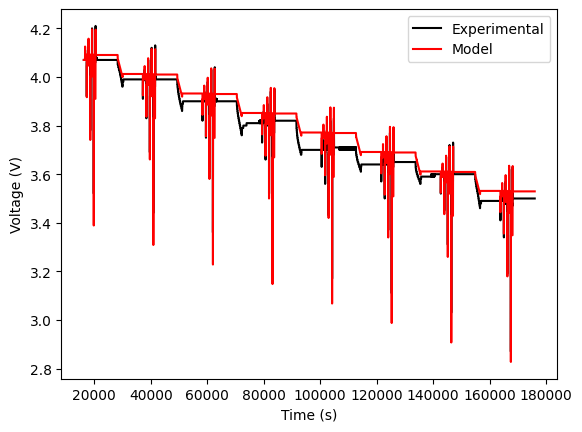

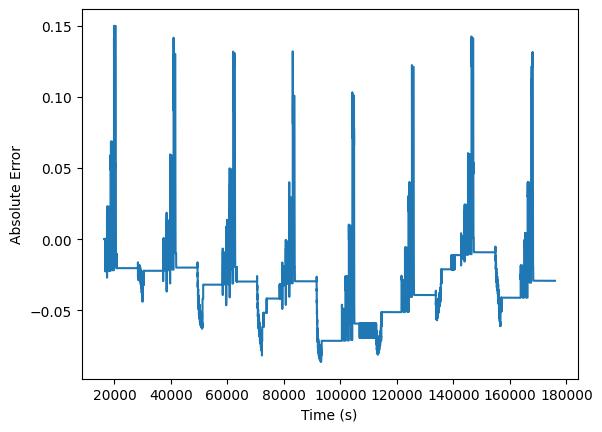

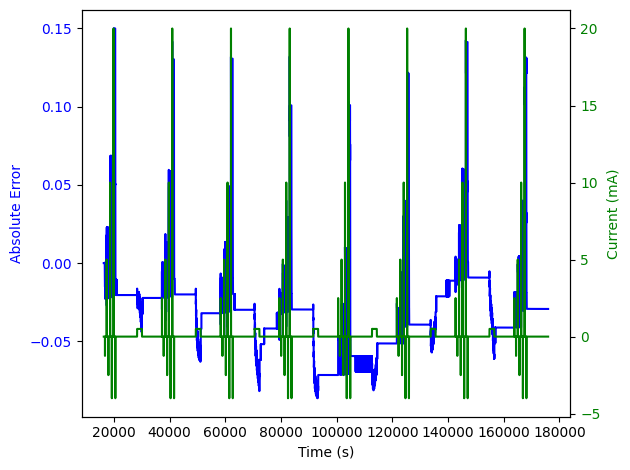

In [ ]:
## Task 2: Parametrisation
# Part A
def FirstOrderECN(t,R0,R1,C1,I,dt,OCV):
    # Initialize i_R1
    i_R1 = np.zeros(len(t))

    # Simulate i_R1 evolution
    for j in range(1, len(t)):
        i_R1[j] = np.exp(-dt/(R1*C1))*i_R1[j-1] + (1-np.exp(-dt/(R1*C1)))*I[j-1]

    #Calculate cell voltage
    modelvol = OCV-(R1*i_R1)-(R0*I)
    return modelvol

def FitFirstOrderECN(t, I, V, dt, OCV):
    # Objective function to minimize
    def objective_function(t, params, I, V, dt, OCV):
        R0, R1, C1 = params
        predvoltage = FirstOrderECN(t, R0, R1, C1, I, dt, OCV)
        residual = predvoltage - V
        return residual

    # Parameters initial guesses (R0, R1, C1)
    InitialGuess = (0.04, 0.005, 5000)

    # Define the objective function with fixed dt and OCV
    obj_func = lambda params: objective_function(t, params, I, V, dt, OCV)
    result = least_squares(obj_func, InitialGuess)

    # Extract the optimized parameters
    optimized_params = result.x
    return optimized_params

# Task 1 Model Updated
def Model():
    # read csv containing training data Temp: 20ºC
    df = pd.read_csv('Model_Training_Data_20.csv')
    t = np.array(df['Time (s)'][:])
    I = np.array(df['Current (A)'][:])
    V = np.array(df['Voltage (V)'][:])

    # interested in discharge data
    t = t[18000:]
    I = -I[18000:]
    V = V[18000:]

    # Read the CSV file with space-separated values
    df = pd.read_csv('SOC_OCV_MFCTT_2019.csv', delim_whitespace=True)

    # Extract SOC and OCV data
    SOC_raw = df['SOC'].values
    OCV_raw = df['Ecell/V'].values

    # read csv containing OCV data
    #df = pd.read_csv('SOC_OCV_MFCTT_2019.csv')

    #SOC_raw = np.array(df['SOC'][:])
    #OCV_raw = np.array(df['Ecell/V'][:])

    dSOC = SOC_raw[0]-SOC_raw[1] # SOC step
    dt = t[1]-t[0] # time step

    Qn = 2500 # nominal capacity in mAh

    SOC = np.zeros(np.shape(t)) # SOC at each time step in discharge

    # calculating initial SOC - will match OCV due to long hold
    found = 0
    i = 0
    while not found:
        if V[0] > OCV_raw[i]:
            if abs(V[0] - OCV_raw[i]) < abs(V[0] - OCV_raw[i-1]):
                SOC[0] = SOC_raw[i]
            else:
                SOC[0] = SOC_raw[i-1]
            found = 1
        else:
            i += 1

    for j in range(1,len(t)):
        SOC[j] = SOC[j-1] - 100*(I[j]*dt/3600)/Qn # SOC as percentage

    SOC_ind = ((SOC_raw[0]-SOC)/dSOC-3).astype(int) # array with index corresponding to current SOC value
    OCV = OCV_raw[SOC_ind] # OCV at each time step in discharge

    # Perform optimization
    optimized_params = FitFirstOrderECN(t, I, V, dt, OCV)
    print("Optimized Parameters (First Order ECN):", optimized_params)

    # In-series resistor 1
    R0 = optimized_params[0] # Resistance 1
    # Parallel resistor 2-capacitor
    R1 = optimized_params[1] # Resistance 2
    C1 = optimized_params[2] # Capacitor 2

    # Calculate model voltage
    V_model = FirstOrderECN(t, R0, R1, C1, I, dt, OCV)

    plt.plot(t,V,'k')
    plt.plot(t,V_model,'r')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend(['Experimental','Model'])
    plt.show()

    err = V-V_model # Error between experimental and model voltage
    plt.plot(t,err)
    plt.xlabel('Time (s)')
    plt.ylabel('Absolute Error')
    plt.show()

    # Overlaying current
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Absolute Error', c='b')
    ax1.plot(t,err,'b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Current (mA)', c='g')
    ax2.plot(t,I,'g')
    ax2.tick_params(axis='y', labelcolor='g')

    fig.tight_layout()
    plt.show()

Model()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV file with space and tab-separated values
df_soc = pd.read_csv('SOC_OCV_MFCTT_2019.csv', delimiter='\t')

# Extract SOC and OCV data
SOC_raw = df_soc['SOC\tEcell/V'].str.split('\t', expand=True)[0].astype(float).values
OCV_raw = df_soc['SOC\tEcell/V'].str.split('\t', expand=True)[1].astype(float).values

# Interpolate SOC-OCV data
def interpolate_SOC(OCV_raw, SOC_raw, OCV_values):
    interpolated_SOC = np.interp(OCV_values, OCV_raw, SOC_raw)
    return interpolated_SOC

# Read CSV file containing training data Temp: 20ºC
df = pd.read_csv('Model_Training_Data_20.csv')
t = np.array(df['Time (s)'][:])
I = np.array(df['Current (A)'][:])
V = np.array(df['Voltage (V)'][:])

# Function to identify pulse intervals (threshold of 0.5 given )
def identify_pulses(I, threshold=0.5, pulse_duration=10):
    pulses = []
    in_pulse = False
    pulse_start = 0

    for i in range(1, len(I)):
        if abs(I[i] - I[i-1]) > threshold:
            if not in_pulse:
                pulse_start = i - 1
                in_pulse = True
        elif in_pulse:
            if i - pulse_start >= pulse_duration * 100:  # Check if pulse duration is approximately 10 seconds
                pulses.append((pulse_start, i))
                in_pulse = False

    if in_pulse:
        pulses.append((pulse_start, len(I)))

    return pulses

# Function to analyze SOC intervals
def analyze_SOC_intervals(t, I, pulses, OCV_values):
    SOC_intervals = []
    for start, end in pulses:
        pulse_start_time = t[start]
        pulse_end_time = t[end-1]
        mean_OCV = np.mean(OCV_values[start:end])
        SOC_intervals.append((pulse_start_time, pulse_end_time, mean_OCV))

    return SOC_intervals

# Analyzing pulses using interpolated SOC for each SOC level
OCV_values = V  # Assuming Voltage (V) corresponds to OCV
interpolated_SOC = interpolate_SOC(OCV_raw, SOC_raw, OCV_values)

# Identify pulses
pulses = identify_pulses(I)
print(pulses[0])
# Analyze SOC intervals for each pulse
SOC_intervals = analyze_SOC_intervals(t, I, pulses, OCV_values)

# Print analysis
print("Pulse Analysis:")
for idx, interval in enumerate(SOC_intervals):
    print(f"Pulse {idx + 1}: Start Time: {interval[0]}, End Time: {interval[1]}, Mean OCV: {interval[2]} V")

# Plot pulses
plt.figure(figsize=(10, 6))
plt.plot(t, I, label='Current (A)', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('Discharge Pulses')
plt.grid(True)

# Plot pulse 1
tpulse = np.zeros([len(t),8])
Ipulse = np.zeros([len(t),8])
Vpulse = np.zeros([len(t),8])
pulserange = np.zeros([8,8])
Pulse = np.matrix([len(tpulse), len(tpulse), len(tpulse), len(tpulse)])
SOCTot = np.array_split(pulses,8)
SOCind = np.matrix(8)
for i in range(8):
  SOC = SOCTot[i]
  for j in range(8):
    jj=0
    pulserange = SOC[j,:]
    for k in range(pulserange[0], pulserange[1]):
      for g in range(len(t)):
        if int(t[g]) == int(k):
          tpulse[jj,j] = t[g]
          Ipulse[jj,j] = I[g]
          Vpulse[jj,j] = V[g]
          jj = jj+1
    Pulse = [j, tpulse, Ipulse, Vpulse]
  SOCind[i] = Pulse
  print(SOCind[i])
print(SOCind)

plt.figure(figsize=(10, 6))
plt.plot(t, I, label='Current (A)', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('Discharge Pulses')
plt.grid(True)

# Highlight pulses
for idx, (start, end) in enumerate(pulses):
    plt.axvspan(t[start], t[end-1], color='orange', alpha=0.3, label=f'Pulse {idx + 1}')

#plt.legend()
plt.show()



(16141, 17141)
Pulse Analysis:
Pulse 1: Start Time: 16139.76901, End Time: 16239.633, Mean OCV: 4.0605400000000005 V
Pulse 2: Start Time: 16749.931, End Time: 16849.79301, Mean OCV: 4.081259999999999 V
Pulse 3: Start Time: 17370.091, End Time: 17469.957, Mean OCV: 4.0483899999999995 V
Pulse 4: Start Time: 17980.255, End Time: 18080.119, Mean OCV: 4.093579999999999 V
Pulse 5: Start Time: 18600.417, End Time: 18700.27901, Mean OCV: 4.02503 V
Pulse 6: Start Time: 19210.577, End Time: 19310.437, Mean OCV: 4.11022 V
Pulse 7: Start Time: 19835.735, End Time: 19935.599, Mean OCV: 3.982369999999999 V
Pulse 8: Start Time: 20445.897, End Time: 20545.759, Mean OCV: 4.143070000000001 V
Pulse 9: Start Time: 37236.148, End Time: 37336.012, Mean OCV: 3.972989999999999 V
Pulse 10: Start Time: 37846.31, End Time: 37946.172, Mean OCV: 4.000090000000001 V
Pulse 11: Start Time: 38466.47, End Time: 38566.334, Mean OCV: 3.9606499999999993 V
Pulse 12: Start Time: 39076.632, End Time: 39176.494, Mean OCV: 4.0

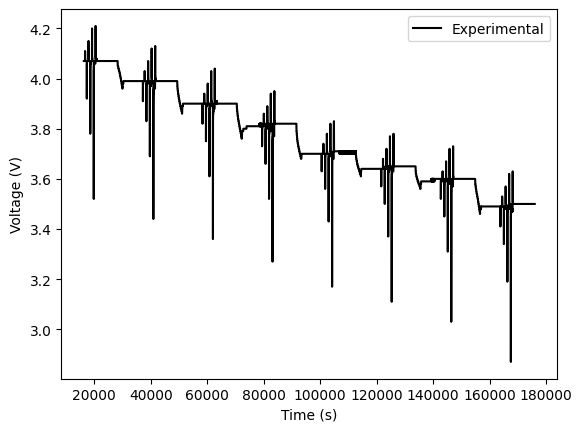

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares

## Plot 20ºC Pulse test: Polarisation visible during discharge and rest

def ThModel():
    # read csv containing training data Temp: 20ºC
    df = pd.read_csv('Model_Training_Data_20.csv')
    t = np.array(df['Time (s)'][:])
    I = np.array(df['Current (A)'][:])
    V = np.array(df['Voltage (V)'][:])

    # interested in discharge data
    t = t[18000:]
    I = -I[18000:]
    V = V[18000:]

    fig, ax1 = plt.subplots()
    plt.plot(t,V,'k')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend(['Experimental','Model'])
    plt.show()

    fig, ax2 = plt.subplots()
    plt.plot(t,I,'k')
    plt.xlabel('Time (s)')
    plt.ylabel('Current (A)')
    plt.legend(['Experimental','Model'])
    plt.show()

ThModel()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares

## Task 2: Parametrisation
# Part A
def FirstOrderECN(t,R0,R1,C1,I,dt,OCV):
    # Initialize i_R1
    i_R1 = np.zeros(len(t))

    # Simulate i_R1 evolution
    for j in range(1, len(t)):
        i_R1[j] = np.exp(-dt/(R1*C1))*i_R1[j-1] + (1-np.exp(-dt/(R1*C1)))*I[j-1]

    #Calculate cell voltage
    modelvol = OCV-(R1*i_R1)-(R0*I)
    return modelvol

def FitFirstOrderECN(t, I, V, dt, OCV):
    # Objective function to minimize
    def objective_function(t, params, I, V, dt, OCV):
        R0, R1, C1 = params
        predvoltage = FirstOrderECN(t, R0, R1, C1, I, dt, OCV)
        residual = predvoltage - V
        return residual

    # Parameters initial guesses (R0, R1, C1)
    InitialGuess = (1, 1, 1)

    # Define the objective function with fixed dt and OCV
    obj_func = lambda params: objective_function(t, params, I, V, dt, OCV)
    result = least_squares(obj_func, InitialGuess)

    # Extract the optimized parameters
    optimized_params = result.x
    return optimized_params

# Task 1 Model Updated
def ThModel():
    # read csv containing training data Temp: 20ºC
    df = pd.read_csv('Model_Training_Data_20.csv')
    t = np.array(df['Time (s)'][:])
    I = np.array(df['Current (A)'][:])
    V = np.array(df['Voltage (V)'][:])

    # interested in discharge data
    t = t[18000:]
    I = -I[18000:]
    V = V[18000:]

    # Read the CSV file with space-separated values
    df = pd.read_csv('SOC_OCV_MFCTT_2019.csv', delim_whitespace=True)

    # Extract SOC and OCV data
    SOC_raw = df['SOC'].values
    OCV_raw = df['Ecell/V'].values

    dSOC = SOC_raw[0]-SOC_raw[1] # SOC step
    dt = t[1]-t[0] # time step

    # Immediate voltage jump in current pulse application
    dv0 =
    di =
    R0 = dv0/di

    # Steady-state voltage change
    dvinf =
    R1 = (dvinf/di) - R0

    # Time to settle after pulse application
    dt =
    C1 = dt/(4*R1)

    Qn = 2500 # nominal capacity in mAh
    R0 = 0.0187 # Thevenin resistance in Ohms

    SOC = np.zeros(np.shape(t)) # SOC at each time step in discharge

    # calculating initial SOC - will match OCV due to long hold
    found = 0
    i = 0
    while not found:
        if V[0] > OCV_raw[i]:
            if abs(V[0] - OCV_raw[i]) < abs(V[0] - OCV_raw[i-1]):
                SOC[0] = SOC_raw[i]
            else:
                SOC[0] = SOC_raw[i-1]
            found = 1
        else:
            i += 1

    for j in range(1,len(t)):
        SOC[j] = SOC[j-1] - 100*(I[j]*dt/3600)/Qn # SOC as percentage

    SOC_ind = ((SOC_raw[0]-SOC)/dSOC-3).astype(int) # array with index corresponding to current SOC value
    OCV = OCV_raw[SOC_ind] # OCV at each time step in discharge

    # Calculate model voltage
    V_model = FirstOrderECN(t, R0, R1, C1, I, dt, OCV)

    plt.plot(t,V,'k')
    plt.plot(t,V_model,'r')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend(['Experimental','Model'])
    plt.show()

    err = V-V_model # Error between experimental and model voltage
    plt.plot(t,err)
    plt.xlabel('Time (s)')
    plt.ylabel('Absolute Error')
    plt.show()

    # Overlaying current
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Absolute Error', c='b')
    ax1.plot(t,err,'b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Current (mA)', c='g')
    ax2.plot(t,I,'g')
    ax2.tick_params(axis='y', labelcolor='g')

    fig.tight_layout()
    plt.show()

ThModel()